In [8]:
%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

In [18]:
from torchsummary import summary
import torch
use_cuda=torch.cuda.is_available()
import pytorch
from pytorch import dataset as ptd

import os
import datasets
import pytorch_models
import torch.optim as optim
dataset_name="fashion_mnist"
(x_train, y_train), (x_test, y_test), input_shape,num_classes = datasets.get_data(dataset_name)
dataset=ptd.ClassificationDataset(dataset_name,x_train,x_test,y_train,y_test,num_classes,input_shape)

print('x_train shape:', x_train.shape,x_train.dtype)
print('x_test shape:', x_test.shape,x_test.dtype)
print('y_train shape:', y_train.shape,y_train.dtype)
print('y_test shape:', y_test.shape,y_test.dtype)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


import numpy as np
print(np.unique(y_train.argmax(axis=1)))
print(y_train.min(),y_train.max())


x_train shape: (60000, 28, 28, 1) uint8
x_test shape: (10000, 28, 28, 1) uint8
y_train shape: (60000, 10) float64
y_test shape: (10000, 10) float64
60000 train samples
10000 test samples
[0 1 2 3 4 5 6 7 8 9]
0.0 1.0


In [20]:
from pytorch import training

import pytorch_models

conv_filters={"mnist":32,"mnist_rot":32,"cifar10":64,"fashion_mnist":32}
fc_filters={"mnist":64,"mnist_rot":64,"cifar10":128,"fashion_mnist":64}
model = pytorch_models.SimpleConv(input_shape,num_classes,
                                 conv_filters=conv_filters[dataset.name],fc_filters=fc_filters[dataset.name])
#model= pytorch_models.FFNet(input_shape,num_classes)x
if use_cuda:
    model=model.cuda()
parameters=training.add_weight_decay(model.named_parameters(),1e-9)
optimizer = optim.Adam(parameters, lr=0.001)
print(model)

rotated_model= pytorch_models.SimpleConv(input_shape,num_classes,
                                       conv_filters=conv_filters[dataset.name],fc_filters=fc_filters[dataset.name])
if use_cuda:
    rotated_model= rotated_model.cuda()
rotated_parameters=training.add_weight_decay(rotated_model.named_parameters(),1e-9)
rotated_optimizer = optim.Adam(rotated_parameters, lr=0.001)

print(rotated_model)
#summary(model, input_size=[1,28,28])


SimpleConv(
  (conv): SequentialWithIntermediates(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
  )
  (fc): SequentialWithIntermediates(
    (0): Linear(in_features=6272, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)
SimpleConv(
  (conv): SequentialWithIntermediates(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(

Training model with unrotated dataset...


Epoch 1: 100% (batch 938/938)  ==stats==> loss:  0.445, accuracy:  0.836, Time:  0:00:04


Test => Loss: 0.3236, Accuracy: 88.04% (8804/10000)


Epoch 2: 100% (batch 938/938)  ==stats==> loss:  0.265, accuracy:  0.904, Time:  0:00:04


Test => Loss: 0.2585, Accuracy: 90.59% (9059/10000)


Epoch 3: 100% (batch 938/938)  ==stats==> loss:   0.22, accuracy:   0.92, Time:  0:00:05


Test => Loss: 0.2483, Accuracy: 91.27% (9127/10000)


Epoch 4: 100% (batch 938/938)  ==stats==> loss:  0.187, accuracy:  0.932, Time:  0:00:05


Test => Loss: 0.2312, Accuracy: 91.56% (9156/10000)


Epoch 5: 100% (batch 938/938)  ==stats==> loss:  0.163, accuracy:   0.94, Time:  0:00:05


Test => Loss: 0.2399, Accuracy: 91.35% (9135/10000)


Epoch 6: 100% (batch 938/938)  ==stats==> loss:  0.141, accuracy:  0.948, Time:  0:00:04


Test => Loss: 0.2306, Accuracy: 92.34% (9234/10000)


Epoch 7: 100% (batch 938/938)  ==stats==> loss:  0.121, accuracy:  0.955, Time:  0:00:04


Test => Loss: 0.2325, Accuracy: 92.22% (9222/10000)


Epoch 8: 100% (batch 938/938)  ==stats==> loss:  0.102, accuracy:  0.963, Time:  0:00:04


Test => Loss: 0.2623, Accuracy: 92.14% (9214/10000)


Epoch 9: 100% (batch 938/938)  ==stats==> loss: 0.0866, accuracy:  0.968, Time:  0:00:05


Test => Loss: 0.2604, Accuracy: 92.62% (9262/10000)


Epoch 10: 100% (batch 938/938)  ==stats==> loss: 0.0713, accuracy:  0.974, Time:  0:00:04


Test => Loss: 0.2789, Accuracy: 92.15% (9215/10000)


Epoch 11: 100% (batch 938/938)  ==stats==> loss: 0.0614, accuracy:  0.977, Time:  0:00:04


Test => Loss: 0.3131, Accuracy: 92.05% (9205/10000)


Epoch 12: 100% (batch 938/938)  ==stats==> loss: 0.0537, accuracy:   0.98, Time:  0:00:04


Test => Loss: 0.3647, Accuracy: 92.14% (9214/10000)


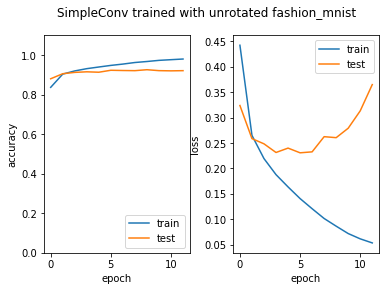

Skipping pretraining rotated model with unrotated dataset
Training rotated model with rotated dataset...


Epoch 1: 100% (batch 938/938)  ==stats==> loss:   1.04, accuracy:  0.609, Time:  0:00:07


Test => Loss: 0.7814, Accuracy: 70.43% (7043/10000)


Epoch 2: 100% (batch 938/938)  ==stats==> loss:  0.686, accuracy:  0.743, Time:  0:00:07


Test => Loss: 0.6321, Accuracy: 77.34% (7734/10000)


Epoch 3: 100% (batch 938/938)  ==stats==> loss:  0.572, accuracy:  0.792, Time:  0:00:07


Test => Loss: 0.5754, Accuracy: 79.05% (7905/10000)


Epoch 4: 100% (batch 938/938)  ==stats==> loss:    0.5, accuracy:  0.819, Time:  0:00:07


Test => Loss: 0.4894, Accuracy: 82.34% (8234/10000)


Epoch 5: 100% (batch 938/938)  ==stats==> loss:  0.462, accuracy:  0.834, Time:  0:00:07


Test => Loss: 0.4798, Accuracy: 82.41% (8241/10000)


Epoch 6: 100% (batch 938/938)  ==stats==> loss:  0.437, accuracy:  0.842, Time:  0:00:07


Test => Loss: 0.4528, Accuracy: 83.64% (8364/10000)


Epoch 7: 100% (batch 938/938)  ==stats==> loss:  0.416, accuracy:  0.851, Time:  0:00:07


Test => Loss: 0.4435, Accuracy: 84.14% (8414/10000)


Epoch 8: 100% (batch 938/938)  ==stats==> loss:  0.399, accuracy:  0.856, Time:  0:00:07


Test => Loss: 0.4068, Accuracy: 85.48% (8548/10000)


Epoch 9: 100% (batch 938/938)  ==stats==> loss:  0.392, accuracy:  0.857, Time:  0:00:07


Test => Loss: 0.4205, Accuracy: 84.97% (8497/10000)


Epoch 10: 100% (batch 938/938)  ==stats==> loss:  0.379, accuracy:  0.863, Time:  0:00:07


Test => Loss: 0.4335, Accuracy: 84.57% (8457/10000)


Epoch 11: 100% (batch 938/938)  ==stats==> loss:  0.369, accuracy:  0.866, Time:  0:00:07


Test => Loss: 0.4323, Accuracy: 84.26% (8426/10000)


Epoch 12: 100% (batch 938/938)  ==stats==> loss:  0.362, accuracy:  0.869, Time:  0:00:07


Test => Loss: 0.4140, Accuracy: 85.05% (8505/10000)


Epoch 13: 100% (batch 938/938)  ==stats==> loss:  0.354, accuracy:  0.872, Time:  0:00:07


Test => Loss: 0.4033, Accuracy: 85.71% (8571/10000)


Epoch 14: 100% (batch 938/938)  ==stats==> loss:  0.347, accuracy:  0.874, Time:  0:00:07


Test => Loss: 0.3638, Accuracy: 86.80% (8680/10000)


Epoch 15: 100% (batch 938/938)  ==stats==> loss:  0.344, accuracy:  0.875, Time:  0:00:07


Test => Loss: 0.3723, Accuracy: 86.74% (8674/10000)


Epoch 16: 100% (batch 938/938)  ==stats==> loss:  0.338, accuracy:  0.876, Time:  0:00:07


Test => Loss: 0.3595, Accuracy: 86.76% (8676/10000)


Epoch 17: 100% (batch 938/938)  ==stats==> loss:   0.33, accuracy:   0.88, Time:  0:00:08


Test => Loss: 0.3694, Accuracy: 86.50% (8650/10000)


Epoch 18: 100% (batch 938/938)  ==stats==> loss:  0.329, accuracy:   0.88, Time:  0:00:08


Test => Loss: 0.3596, Accuracy: 86.95% (8695/10000)


Epoch 19: 100% (batch 938/938)  ==stats==> loss:  0.324, accuracy:  0.882, Time:  0:00:08


Test => Loss: 0.3573, Accuracy: 87.37% (8737/10000)


Epoch 20: 100% (batch 938/938)  ==stats==> loss:  0.324, accuracy:  0.883, Time:  0:00:08


Test => Loss: 0.3613, Accuracy: 87.07% (8707/10000)


Epoch 21: 100% (batch 938/938)  ==stats==> loss:  0.315, accuracy:  0.886, Time:  0:00:08


Test => Loss: 0.3555, Accuracy: 87.40% (8740/10000)


Epoch 22: 100% (batch 938/938)  ==stats==> loss:  0.314, accuracy:  0.887, Time:  0:00:08


Test => Loss: 0.3629, Accuracy: 87.08% (8708/10000)


Epoch 23: 100% (batch 938/938)  ==stats==> loss:   0.31, accuracy:  0.888, Time:  0:00:08


Test => Loss: 0.3482, Accuracy: 87.52% (8752/10000)


Epoch 24: 100% (batch 938/938)  ==stats==> loss:  0.306, accuracy:  0.888, Time:  0:00:07


Test => Loss: 0.3403, Accuracy: 87.52% (8752/10000)


Epoch 25: 100% (batch 938/938)  ==stats==> loss:  0.304, accuracy:  0.889, Time:  0:00:07


Test => Loss: 0.3523, Accuracy: 87.45% (8745/10000)


Epoch 26: 100% (batch 938/938)  ==stats==> loss:  0.303, accuracy:   0.89, Time:  0:00:07


Test => Loss: 0.3396, Accuracy: 87.93% (8793/10000)


Epoch 27: 100% (batch 938/938)  ==stats==> loss:  0.299, accuracy:  0.891, Time:  0:00:07


Test => Loss: 0.3430, Accuracy: 87.78% (8778/10000)


Epoch 28: 100% (batch 938/938)  ==stats==> loss:  0.296, accuracy:  0.894, Time:  0:00:07


Test => Loss: 0.3491, Accuracy: 87.54% (8754/10000)


Epoch 29: 100% (batch 938/938)  ==stats==> loss:  0.299, accuracy:  0.892, Time:  0:00:07


Test => Loss: 0.3410, Accuracy: 87.97% (8797/10000)


Epoch 30: 100% (batch 938/938)  ==stats==> loss:  0.295, accuracy:  0.894, Time:  0:00:07


Test => Loss: 0.3360, Accuracy: 87.79% (8779/10000)


Epoch 31: 100% (batch 938/938)  ==stats==> loss:  0.293, accuracy:  0.893, Time:  0:00:07


Test => Loss: 0.3204, Accuracy: 88.27% (8827/10000)


Epoch 32: 100% (batch 938/938)  ==stats==> loss:  0.291, accuracy:  0.895, Time:  0:00:07


Test => Loss: 0.3299, Accuracy: 88.51% (8851/10000)


Epoch 33: 100% (batch 938/938)  ==stats==> loss:  0.287, accuracy:  0.894, Time:  0:00:07


Test => Loss: 0.3269, Accuracy: 88.47% (8847/10000)


Epoch 34: 100% (batch 938/938)  ==stats==> loss:   0.29, accuracy:  0.894, Time:  0:00:07


Test => Loss: 0.3252, Accuracy: 88.41% (8841/10000)


Epoch 35: 100% (batch 938/938)  ==stats==> loss:  0.287, accuracy:  0.896, Time:  0:00:07


Test => Loss: 0.3237, Accuracy: 88.26% (8826/10000)


Epoch 36: 100% (batch 938/938)  ==stats==> loss:  0.283, accuracy:  0.898, Time:  0:00:07


Test => Loss: 0.3503, Accuracy: 87.55% (8755/10000)


Epoch 37: 100% (batch 938/938)  ==stats==> loss:  0.284, accuracy:  0.897, Time:  0:00:07


Test => Loss: 0.3289, Accuracy: 88.78% (8878/10000)


Epoch 38: 100% (batch 938/938)  ==stats==> loss:  0.283, accuracy:  0.897, Time:  0:00:07


Test => Loss: 0.3339, Accuracy: 88.55% (8855/10000)


Epoch 39: 100% (batch 938/938)  ==stats==> loss:  0.282, accuracy:  0.896, Time:  0:00:07


Test => Loss: 0.3309, Accuracy: 88.62% (8862/10000)


Epoch 40: 100% (batch 938/938)  ==stats==> loss:  0.281, accuracy:  0.899, Time:  0:00:07


Test => Loss: 0.3311, Accuracy: 88.00% (8800/10000)


Epoch 41: 100% (batch 938/938)  ==stats==> loss:  0.276, accuracy:    0.9, Time:  0:00:07


Test => Loss: 0.3246, Accuracy: 88.58% (8858/10000)


Epoch 42: 100% (batch 938/938)  ==stats==> loss:  0.276, accuracy:    0.9, Time:  0:00:07


Test => Loss: 0.3181, Accuracy: 88.75% (8875/10000)


Epoch 43: 100% (batch 938/938)  ==stats==> loss:  0.278, accuracy:    0.9, Time:  0:00:07


Test => Loss: 0.3067, Accuracy: 88.84% (8884/10000)


Epoch 44: 100% (batch 938/938)  ==stats==> loss:  0.274, accuracy:  0.901, Time:  0:00:07


Test => Loss: 0.3150, Accuracy: 88.50% (8850/10000)


Epoch 45: 100% (batch 938/938)  ==stats==> loss:  0.273, accuracy:  0.901, Time:  0:00:07


Test => Loss: 0.3261, Accuracy: 88.54% (8854/10000)


Epoch 46: 100% (batch 938/938)  ==stats==> loss:  0.276, accuracy:    0.9, Time:  0:00:07


Test => Loss: 0.3296, Accuracy: 88.30% (8830/10000)


Epoch 47: 100% (batch 938/938)  ==stats==> loss:  0.268, accuracy:  0.901, Time:  0:00:07


Test => Loss: 0.3101, Accuracy: 88.96% (8896/10000)


Epoch 48: 100% (batch 938/938)  ==stats==> loss:  0.271, accuracy:  0.902, Time:  0:00:07


Test => Loss: 0.3170, Accuracy: 88.70% (8870/10000)


Epoch 49: 100% (batch 938/938)  ==stats==> loss:  0.267, accuracy:  0.902, Time:  0:00:07


Test => Loss: 0.3229, Accuracy: 88.30% (8830/10000)


Epoch 50: 100% (batch 938/938)  ==stats==> loss:   0.27, accuracy:  0.902, Time:  0:00:07


Test => Loss: 0.3161, Accuracy: 88.72% (8872/10000)


Epoch 51: 100% (batch 938/938)  ==stats==> loss:  0.268, accuracy:  0.902, Time:  0:00:07


Test => Loss: 0.3169, Accuracy: 89.40% (8940/10000)


Epoch 52: 100% (batch 938/938)  ==stats==> loss:  0.266, accuracy:  0.903, Time:  0:00:07


Test => Loss: 0.3236, Accuracy: 88.70% (8870/10000)


Epoch 53: 100% (batch 938/938)  ==stats==> loss:  0.263, accuracy:  0.905, Time:  0:00:07


Test => Loss: 0.3164, Accuracy: 89.04% (8904/10000)


Epoch 54: 100% (batch 938/938)  ==stats==> loss:  0.268, accuracy:  0.902, Time:  0:00:07


Test => Loss: 0.3207, Accuracy: 88.58% (8858/10000)


Epoch 55: 100% (batch 938/938)  ==stats==> loss:  0.263, accuracy:  0.904, Time:  0:00:07


Test => Loss: 0.3044, Accuracy: 89.16% (8916/10000)


Epoch 56: 100% (batch 938/938)  ==stats==> loss:  0.264, accuracy:  0.903, Time:  0:00:07


Test => Loss: 0.3257, Accuracy: 88.50% (8850/10000)


Epoch 57: 100% (batch 938/938)  ==stats==> loss:  0.263, accuracy:  0.904, Time:  0:00:07


Test => Loss: 0.3042, Accuracy: 89.35% (8935/10000)


Epoch 58: 100% (batch 938/938)  ==stats==> loss:  0.263, accuracy:  0.905, Time:  0:00:07


Test => Loss: 0.3105, Accuracy: 88.82% (8882/10000)


Epoch 59: 100% (batch 938/938)  ==stats==> loss:  0.262, accuracy:  0.905, Time:  0:00:07


Test => Loss: 0.3141, Accuracy: 88.83% (8883/10000)


Epoch 60: 100% (batch 938/938)  ==stats==> loss:   0.26, accuracy:  0.905, Time:  0:00:07


Test => Loss: 0.3147, Accuracy: 88.81% (8881/10000)


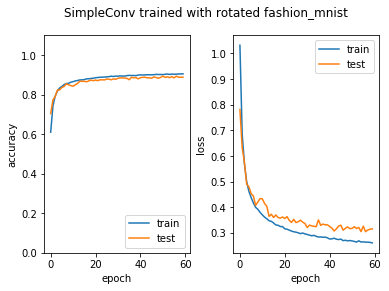

Testing both models on both datasets...


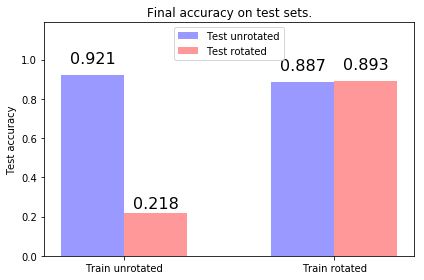

model_rotated_test_dataset score: loss=9.928056, accuracy=0.218100
model_rotated_train_dataset score: loss=9.923144, accuracy=0.222283
model_test_dataset score: loss=0.364709, accuracy=0.921400
model_train_dataset score: loss=0.051701, accuracy=0.981033
rotated_model_rotated_test_dataset score: loss=0.315557, accuracy=0.893300
rotated_model_rotated_train_dataset score: loss=0.255599, accuracy=0.907067
rotated_model_test_dataset score: loss=0.321192, accuracy=0.887300
rotated_model_train_dataset score: loss=0.270589, accuracy=0.903583


In [21]:
batch_size = 64

epochs={'cifar10':5,'mnist':2,'fashion_mnist':12,'cluttered_mnist':10,'lsa16':15,'mnist_rot':5,'pugeault':15}
from pytorch.experiment import rotation
rotated_epochs={'cifar10':100,'mnist':2,'fashion_mnist':60,'cluttered_mnist':30,'lsa16':100,'mnist_rot':5,'pugeault':40}

config=pytorch.experiment.rotation.TrainRotatedConfig(batch_size=batch_size,
                   epochs=epochs[dataset.name],rotated_epochs=rotated_epochs[dataset.name],
                   pre_rotated_epochs=0, optimizer=optimizer,rotated_optimizer=rotated_optimizer,
                  use_cuda=use_cuda)

scores=rotation.run(config,model,rotated_model,dataset,plot_accuracy=True,save_plots=False)
for k,v in scores.items():
    print('%s score: loss=%f, accuracy=%f' % (k,v[0],v[1]))


In [22]:
from pytorch.experiment import invariance_evaluation

n_rotations=16
#results=invariance_evaluation.run(model,dataset,config)
rotated_results,classes,rotations=invariance_evaluation.run(rotated_model,dataset,config,n_rotations)
results,classes,rotations=invariance_evaluation.run(model,dataset,config,n_rotations)




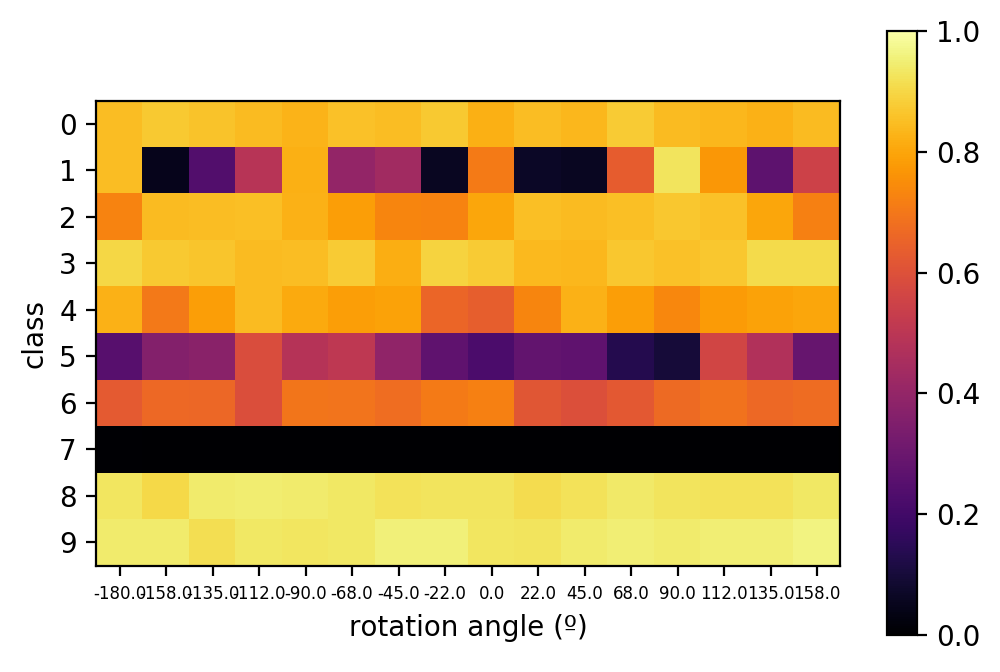

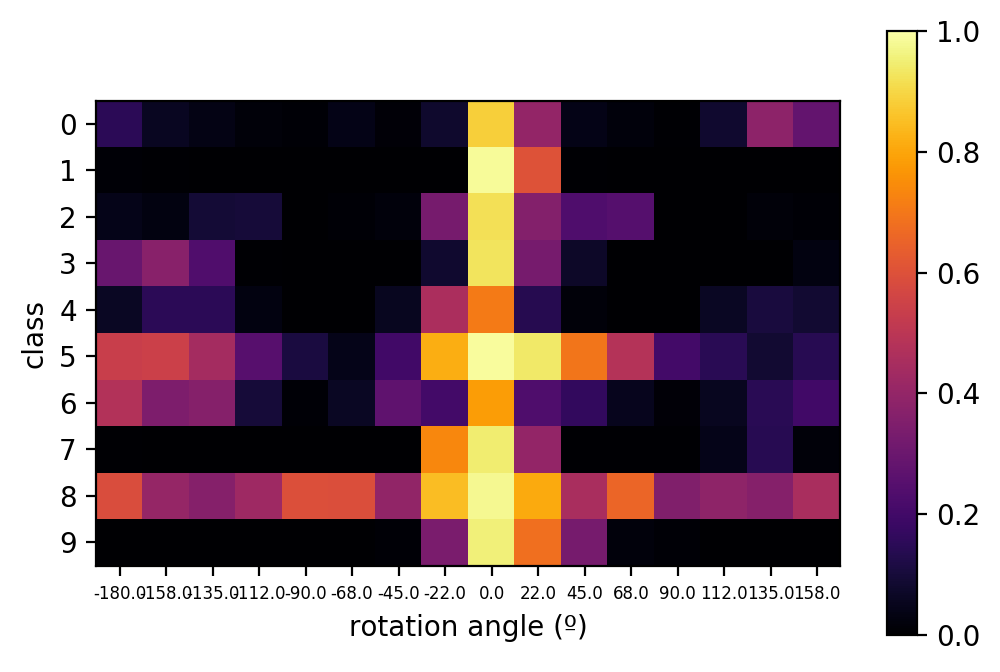

In [23]:
base_folder="plots/invariance_evaluation"
rotated_fig=invariance_evaluation.plot_results(rotated_results,classes,rotations)
name=f"{base_folder}/{dataset.name}_{model.name}_rotated.png"
rotated_fig.savefig(name)

fig=invariance_evaluation.plot_results(results,classes,rotations)
name=f"{base_folder}/{dataset.name}_{model.name}_unrotated.png"
fig.savefig(name)
